In [2]:
import util
from forward import solve_forward
from simulation import Simulation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
# to load large .mat files
import mat73
import random

In [3]:
eeg_topos = mat73.loadmat('/media/thanos/Big Data/Thanos/TUC/Thesis/sim_data/sim_type_1/eeg_topographies.mat')['eeg_arr']
eeg_topos = eeg_topos.transpose(2, 0, 1)

Text(0.5, 1.0, 'Topography for eeg signal: 57697')

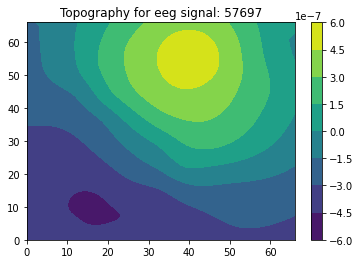

In [4]:
topo_idx = random.randint(0,eeg_topos.shape[0]-1)
topo = eeg_topos[topo_idx,:,:]
plt.contourf(topo, cmap=cm.get_cmap('viridis'))
cbar = plt.colorbar()
plt.draw()
plt.title('Topography for eeg signal: {}'.format(topo_idx+1))

In [5]:
# load previous simulation
sim = util.load_object('/media/thanos/Big Data/Thanos/TUC/Thesis/sim_data/sim_type_1/sim_obj_100k.pkl')
# fwd = solve_forward()
# sim = Simulation(fwd=fwd)
# sim.simulate(n_samples=100)

In [6]:
from net import EEG_CNN
eegcnn = EEG_CNN(sim=sim, eeg_topographies=eeg_topos)

2021-12-11 01:30:49.650968: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-11 01:30:49.651227: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
eegcnn.build_model()

2021-12-11 01:39:23.430387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-11 01:39:23.432344: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-11 01:39:23.434068: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thanos): /proc/driver/nvidia/version does not exist
2021-12-11 01:39:23.481130: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-11 01:39:25.408932: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 69222400 exceeds 10%

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 65, 65, 8)         80        
                                                                 
 flatten (Flatten)           (None, 33800)             0         
                                                                 
 dense (Dense)               (None, 512)               17306112  
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 2048)              2099200   
                                                                 
 OutputLayer (Dense)         (None, 50460)             103392540 
                                                                 
Total params: 123,323,244
Trainable params: 123,323,244


In [8]:
eegcnn.fit()

Epoch 1/50
800/800 [==============================] - 1353s 2s/step - loss: 0.0077 - MAE: 4.2527 - RMSE: 4.6897 - val_loss: 0.0075 - val_MAE: 5.8896 - val_RMSE: 6.3161
Epoch 2/50
800/800 [==============================] - 1086s 1s/step - loss: 0.0076 - MAE: 7.7077 - RMSE: 8.3134 - val_loss: 0.0075 - val_MAE: 9.2765 - val_RMSE: 9.9625
Epoch 3/50
800/800 [==============================] - 1117s 1s/step - loss: 0.0076 - MAE: 10.5950 - RMSE: 11.3555 - val_loss: 0.0075 - val_MAE: 11.7437 - val_RMSE: 12.5738
Epoch 4/50
800/800 [==============================] - 1138s 1s/step - loss: 0.0076 - MAE: 12.8909 - RMSE: 13.7887 - val_loss: 0.0075 - val_MAE: 13.9125 - val_RMSE: 14.8417
Epoch 5/50
800/800 [==============================] - 1148s 1s/step - loss: 0.0076 - MAE: 14.7774 - RMSE: 15.7929 - val_loss: 0.0075 - val_MAE: 15.5845 - val_RMSE: 16.6335
Epoch 6/50
800/800 [==============================] - 1150s 1s/step - loss: 0.0076 - MAE: 16.4229 - RMSE: 17.5411 - val_loss: 0.0075 - val_MAE: 17.2

(<keras.callbacks.History at 0x7ff973fe06a0>,
 'logs/CNN-Model-11/12/2021-01:39:33')

In [9]:
eegcnn.save_nn('/media/thanos/Big Data/Thanos/TUC/Thesis/nn_trained/cnn_model_1.h5')